# Analysis of the Models

In this document, we will look at various models, their explainability and evaluation.

## Import the Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import numpy as np
import pandas as pd

from lib.load_dataset import load_merged_data


WHICH = "2019-2021"
# WHICH = "2022"

X_merged, y_merged, report_ids, patient_ids = load_merged_data(which=WHICH)

TAKE_RANGE = (
    X_merged["RecordCount"].min().iloc[0],
    X_merged["RecordCount"].max().iloc[0],
)

MAX_RECORDS = TAKE_RANGE[1]

In [3]:
X_merged.shape

(21297, 120)

## The Models

### XGB

In [10]:
# Parameters for XGBoost
XGBC_HYPERPARAMS = {
    "objective": "binary:logistic",
    "random_state": 42,
    "enable_categorical": False,

    "n_estimators": 100,
    "max_depth": 7,
    "learning_rate": 0.1,
    "gamma": 0,
    "min_child_weight": 1,
    "subsample": 1,

    # The ratio of negative and positive values
    # "scale_pos_weight": y_val.value_counts()[0] / y_val.value_counts()[1],
}

#### CV Help Function

Help function for cross-validation.

In [119]:
from typing import Any
from lib.eval import cross_validation_merged_df


def do_cross_val(
    model: Any,
    augment_data: bool = False,
    take_cols: list[str] | pd.Series = None,
    each_record_eval: bool = True,
    confusion_matrix_plot: bool = True,
) -> dict[str, Any]:
    """
    Perform cross-validation on the merged dataset.

    Parameters:
        model: Any
            The model to be used for cross-validation.
        
        augment_data: bool
            Whether to augment the data before cross-validation.
        
        take_cols: list[str] | pd.Series
            The columns to be taken from the merged dataset.

        each_record_eval: bool
            Whether to evaluate each record separately.

        confusion_matrix_plot: bool
            Whether to plot the confusion matrix.
    """

    if take_cols is None:
        take_cols = X_merged.columns.drop(["PatientId", "RecordId"])

    return cross_validation_merged_df(
        model,
        TAKE_RANGE[1],
        X_merged.loc[:, take_cols],
        y_merged,
        patient_ids,
        n_splits=5,
        augment_data=augment_data,
        each_record_eval=each_record_eval,
        random_state=42,
        record_count_getter=lambda X: X[("RecordCount", 0)],
        confusion_matrix_plot=confusion_matrix_plot,
    )

#### CV XGB+C

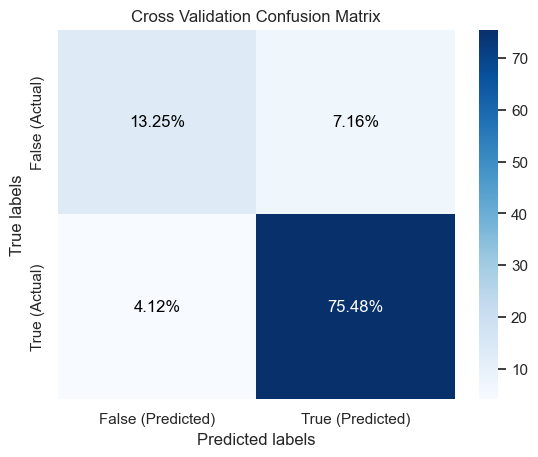

In [120]:
import xgboost as xgb


scores, each_record_scores = do_cross_val(
    xgb.XGBClassifier(**XGBC_HYPERPARAMS)
)

In [121]:
from lib.eval import process_scoring_dict

print(process_scoring_dict(scores))

Test  : Accuracy       : 0.89 ± 0.004
Test  : F1             : 0.70 ± 0.006
Test  : Precision      : 0.76 ± 0.008
Test  : Recall         : 0.65 ± 0.008
Test  : Roc_auc        : 0.93 ± 0.004
Train : Accuracy       : 0.95 ± 0.002
Train : F1             : 0.86 ± 0.005
Train : Precision      : 0.90 ± 0.004
Train : Recall         : 0.83 ± 0.006
Train : Roc_auc        : 0.98 ± 0.001


In [122]:
from lib.eval import process_each_records_scores

print(process_each_records_scores(each_record_scores))

Group 2
Test  : Accuracy       : 0.89 ± 0.005
Test  : F1             : 0.70 ± 0.009
Test  : Precision      : 0.76 ± 0.012
Test  : Recall         : 0.65 ± 0.010
Test  : Roc_auc        : 0.93 ± 0.006
Train : Accuracy       : 0.94 ± 0.002
Train : F1             : 0.85 ± 0.004
Train : Precision      : 0.88 ± 0.004
Train : Recall         : 0.81 ± 0.006
Train : Roc_auc        : 0.98 ± 0.001
---
Group 3
Test  : Accuracy       : 0.87 ± 0.008
Test  : F1             : 0.70 ± 0.023
Test  : Precision      : 0.78 ± 0.020
Test  : Recall         : 0.63 ± 0.040
Test  : Roc_auc        : 0.92 ± 0.004
Train : Accuracy       : 0.98 ± 0.003
Train : F1             : 0.95 ± 0.006
Train : Precision      : 0.97 ± 0.005
Train : Recall         : 0.94 ± 0.008
Train : Roc_auc        : 1.00 ± 0.000
---



#### CV No Diff Dataset

In [33]:
import xgboost as xgb

# Transform columns from MultiIndex to Index
new_cols = pd.Index([f"{col}_{i}" for col, i in X_merged.columns])

take_cols = (~new_cols.str.startswith(("PatientId", "RecordId"))) & (
    ~new_cols.str.contains(r"^.*_Diff_.*$", regex=True)
)

scores_no_diff, each_record_scores_no_diff = do_cross_val(
    xgb.XGBClassifier(**XGBC_HYPERPARAMS),
    take_cols=take_cols,
    confusion_matrix_plot=False,
)

In [35]:
from lib.eval import process_scoring_dict

print(process_scoring_dict(scores_no_diff))

Test  : Accuracy       : 0.89 ± 0.005
Test  : F1             : 0.69 ± 0.010
Test  : Precision      : 0.77 ± 0.013
Test  : Recall         : 0.63 ± 0.014
Test  : Roc_auc        : 0.93 ± 0.004
Train : Accuracy       : 0.94 ± 0.002
Train : F1             : 0.85 ± 0.005
Train : Precision      : 0.91 ± 0.004
Train : Recall         : 0.80 ± 0.007
Train : Roc_auc        : 0.98 ± 0.001


In [31]:
from lib.eval import process_each_records_scores

print(process_each_records_scores(each_record_scores_no_diff))

Group 2
Test  : Accuracy       : 0.89 ± 0.006
Test  : F1             : 0.69 ± 0.015
Test  : Precision      : 0.77 ± 0.016
Test  : Recall         : 0.62 ± 0.018
Test  : Roc_auc        : 0.93 ± 0.006
Train : Accuracy       : 0.94 ± 0.002
Train : F1             : 0.83 ± 0.004
Train : Precision      : 0.89 ± 0.003
Train : Recall         : 0.78 ± 0.006
Train : Roc_auc        : 0.98 ± 0.001
---
Group 3
Test  : Accuracy       : 0.87 ± 0.008
Test  : F1             : 0.70 ± 0.021
Test  : Precision      : 0.78 ± 0.014
Test  : Recall         : 0.64 ± 0.042
Test  : Roc_auc        : 0.91 ± 0.006
Train : Accuracy       : 0.98 ± 0.005
Train : F1             : 0.94 ± 0.011
Train : Precision      : 0.98 ± 0.006
Train : Recall         : 0.92 ± 0.016
Train : Roc_auc        : 1.00 ± 0.001
---



#### CV XGB+CD

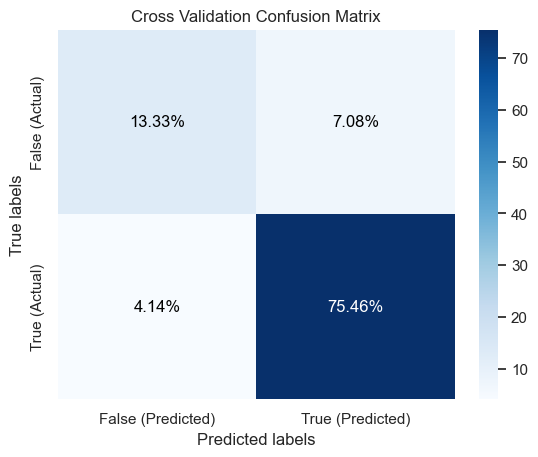

In [42]:
xgb_da_scores, xgb_da_each_rec_score = do_cross_val(
    xgb.XGBClassifier(**XGBC_HYPERPARAMS), augment_data=True
)

In [70]:
from lib.eval import process_scoring_dict

print(process_scoring_dict(xgb_da_scores))

Test  : Accuracy       : 0.89 ± 0.005
Test  : F1             : 0.70 ± 0.016
Test  : Precision      : 0.76 ± 0.012
Test  : Recall         : 0.64 ± 0.020
Test  : Roc_auc        : 0.93 ± 0.005
Train : Accuracy       : 0.95 ± 0.001
Train : F1             : 0.88 ± 0.004
Train : Precision      : 0.91 ± 0.003
Train : Recall         : 0.85 ± 0.006
Train : Roc_auc        : 0.99 ± 0.000


In [74]:
from lib.eval import process_each_records_scores

print(process_each_records_scores(xgb_da_each_rec_score))

Group 2
Test  : Accuracy       : 0.89 ± 0.006
Test  : F1             : 0.70 ± 0.019
Test  : Precision      : 0.76 ± 0.017
Test  : Recall         : 0.65 ± 0.020
Test  : Roc_auc        : 0.93 ± 0.006
Train : Accuracy       : 0.95 ± 0.002
Train : F1             : 0.86 ± 0.005
Train : Precision      : 0.89 ± 0.004
Train : Recall         : 0.83 ± 0.006
Train : Roc_auc        : 0.99 ± 0.001
---
Group 3
Test  : Accuracy       : 0.87 ± 0.005
Test  : F1             : 0.69 ± 0.018
Test  : Precision      : 0.77 ± 0.036
Test  : Recall         : 0.62 ± 0.023
Test  : Roc_auc        : 0.91 ± 0.008
Train : Accuracy       : 0.99 ± 0.002
Train : F1             : 0.97 ± 0.004
Train : Precision      : 0.99 ± 0.004
Train : Recall         : 0.96 ± 0.005
Train : Roc_auc        : 1.00 ± 0.000
---



#### Hyperparameter Tuning

In [ ]:
# Implement hyperparameter tuning using bayesian optimization with hyperopt
import numpy as np
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# fmt: off
space = {
    "n_estimators":     hp.quniform("n_estimators", 50, 120, 10),
    "max_depth":        hp.quniform("max_depth", 5, 8, 1),
    "learning_rate":    hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "gamma":            hp.loguniform("gamma", np.log(0.01), np.log(0.5)),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "subsample":        hp.uniform("subsample", 0.5, 1.0),
}
# fmt: on


def hyperopt_objective(space):
    params = {
        "objective": "binary:logistic",
        "n_estimators": int(space["n_estimators"]),
        "max_depth": int(space["max_depth"]),
        "learning_rate": space["learning_rate"],
        "random_state": 42,
        "enable_categorical": False,
    }

    scores = do_cross_val(
        xgb.XGBClassifier(**params),
        augment_data=False,
        each_record_eval=False,
        confusion_matrix_plot=False,
    )

    # loss = -scores["test_f1"].mean()
    # loss = -scores["test_precision"].mean()
    loss = -scores["test_accuracy"].mean()

    return {
        "loss": loss,
        "status": STATUS_OK,
    }


trials = Trials()

best = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
)

# Show the best hyperparameters
{k: round(v, 3) for k, v in best.items()}

### Logistic Regression

In [50]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

from lib.eval import evaluate_model

lr_params = {
    "random_state": 42,
    "solver": "liblinear",
    "penalty": "l2",
}

lr = LogisticRegression(**lr_params)

# Standardize the data
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaler.fit(X_merged)

def scaled_df(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        standard_scaler.transform(df), columns=df.columns, index=df.index
    )

lr.fit(scaled_df(X_merged), y_merged)
None

In [51]:
def explain_vars_regression(model, X: pd.DataFrame) -> pd.DataFrame:
    """
    Retrurns the weights of the model.
    """

    return (
        pd.DataFrame({"feature": X.columns, "weight": model.coef_[0]})
        .sort_values(by="weight", ascending=False)
        .reset_index(drop=True)
    )

In [52]:
from IPython.display import display

lr_explained = explain_vars_regression(lr, X_merged)
display(lr_explained.head(10))
display(lr_explained.tail(10))

,feature,weight
0,"(NoveltyRank, 2)",0.476914
1,"(ICDRangeC76-C80, 1)",0.348919
2,"(ICD, 1)",0.286320
3,"(MorphHistology_Diff, 2)",0.259091
4,"(MorphHistology_Diff, 1)",0.246945
5,"(MorphBehavior, 1)",0.243808
6,"(CodeEstablishingDg, 0)",0.241181
7,"(NoveltyRank, 0)",0.226052
8,"(ClinicalStadium_Diff, 2)",0.217163
9,"(CodeEstablishingDg, 2)",0.216732


,feature,weight
112,"(YearDg_Diff, 2)",-0.182521
113,"(MorphHistology, 0)",-0.182834
114,"(MorphBehavior_Diff, 1)",-0.197579
115,"(UnknownCount, 2)",-0.204356
116,"(ICD_Diff, 1)",-0.258149
117,"(ICDRangeC76-C80, 2)",-0.277638
118,"(MorphHistology, 1)",-0.477042
119,"(Row_Similarity, 1)",-0.499642
120,"(MorphHistology, 2)",-0.526015
121,"(ICDRangeC76-C80, 0)",-0.655298


#### CV

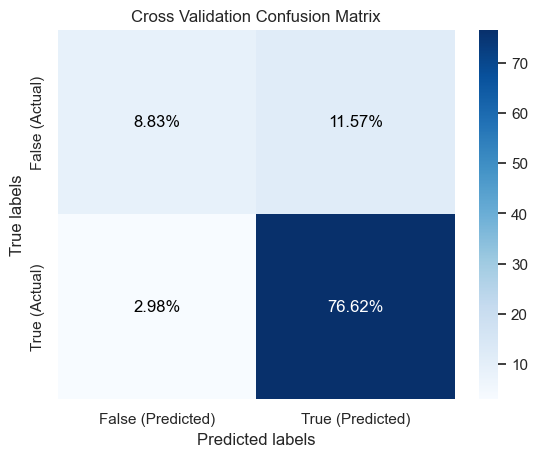

In [65]:
from sklearn.linear_model import LogisticRegression

lr_params = {
    "random_state": 42,
    "solver": "liblinear",
    "penalty": "l2",
}

lr = LogisticRegression(**lr_params)

to_drop = []
"""
Drop the columns that are not of the first record
or they are not differences to reduce the number of columns.
With all columns present, the model is underperforming.
"""
for colname, idx in X_merged.columns:
    if idx != 0 and "Diff" not in colname:
        to_drop.append((colname, idx))

take_cols = X_merged.columns.drop(to_drop + ["RecordId", "PatientId"])

lr_scores, lr_each_record_scores = do_cross_val(lr, take_cols=take_cols)

In [66]:
from lib.eval import process_scoring_dict

print(process_scoring_dict(lr_scores))

Test  : Accuracy       : 0.85 ± 0.005
Test  : F1             : 0.55 ± 0.009
Test  : Precision      : 0.75 ± 0.013
Test  : Recall         : 0.43 ± 0.009
Test  : Roc_auc        : 0.86 ± 0.004
Train : Accuracy       : 0.86 ± 0.002
Train : F1             : 0.55 ± 0.009
Train : Precision      : 0.75 ± 0.009
Train : Recall         : 0.43 ± 0.010
Train : Roc_auc        : 0.86 ± 0.002


## Feature Explanation

### SHAP -- XGB+C

In [5]:
import shap

shap.initjs()

In [6]:
X_explained = X_merged.copy()
y_explained = y_merged.copy()

X_explained.drop(columns=["RecordId", "PatientId"], level=0, inplace=True)

In [11]:
import xgboost as xgb

xgbc_shap = xgb.XGBClassifier(**XGBC_HYPERPARAMS)
xgbc_shap.fit(X_explained, y_explained)

y_pred_explained = pd.Series(
    xgbc_shap.predict(X_explained), index=X_explained.index
)

# Rename columns for shap
renamed_cols = []
for col in X_explained.columns:
    if col[1] != "":
        renamed_cols.append("_".join([str(y) for y in col]))
    else:
        renamed_cols.append(col[0])

X_explained.columns = renamed_cols

explainer = shap.TreeExplainer(xgbc_shap)

# Calculate shap values
shap_values = explainer(X_explained)

[19:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


#### Importance of Features by SHAP

In [142]:
feature_names = X_explained.columns
shap_vals_df = pd.DataFrame(shap_values.values, columns=feature_names)

vals = np.abs(shap_vals_df.values).mean(0)

shap_importance = pd.DataFrame(
    list(zip(feature_names, vals)),
    columns=["col_name", "feature_importance_vals"],
)
shap_importance.sort_values(
    by=["feature_importance_vals"], ascending=False, inplace=True
)

shap_importance = shap_importance.round(3)


def print_shap_importances():
    for i in range(10):
        to_print = ""
        for val in shap_importance.iloc[i].values:
            if len(to_print) > 0:
                to_print += " & "
            if str(val) == val:
                to_print += "\\texttt{" + val + "}"
            else:
                to_print += str(val)

        to_print += " \\\\"

        print(to_print)


shap_importance.head(10)

,col_name,feature_importance_vals
33,ICDRangeC76-C80_0,0.546
24,ClinicalStadium_0,0.393
98,Topography_Diff_1,0.299
94,ICD_Diff_1,0.267
102,MorphHistology_Diff_1,0.249
57,T_0,0.178
36,ICD_0,0.175
0,CodeEstablishingDg_0,0.173
108,T_Diff_1,0.168
37,ICD_1,0.160


#### Summary Plot

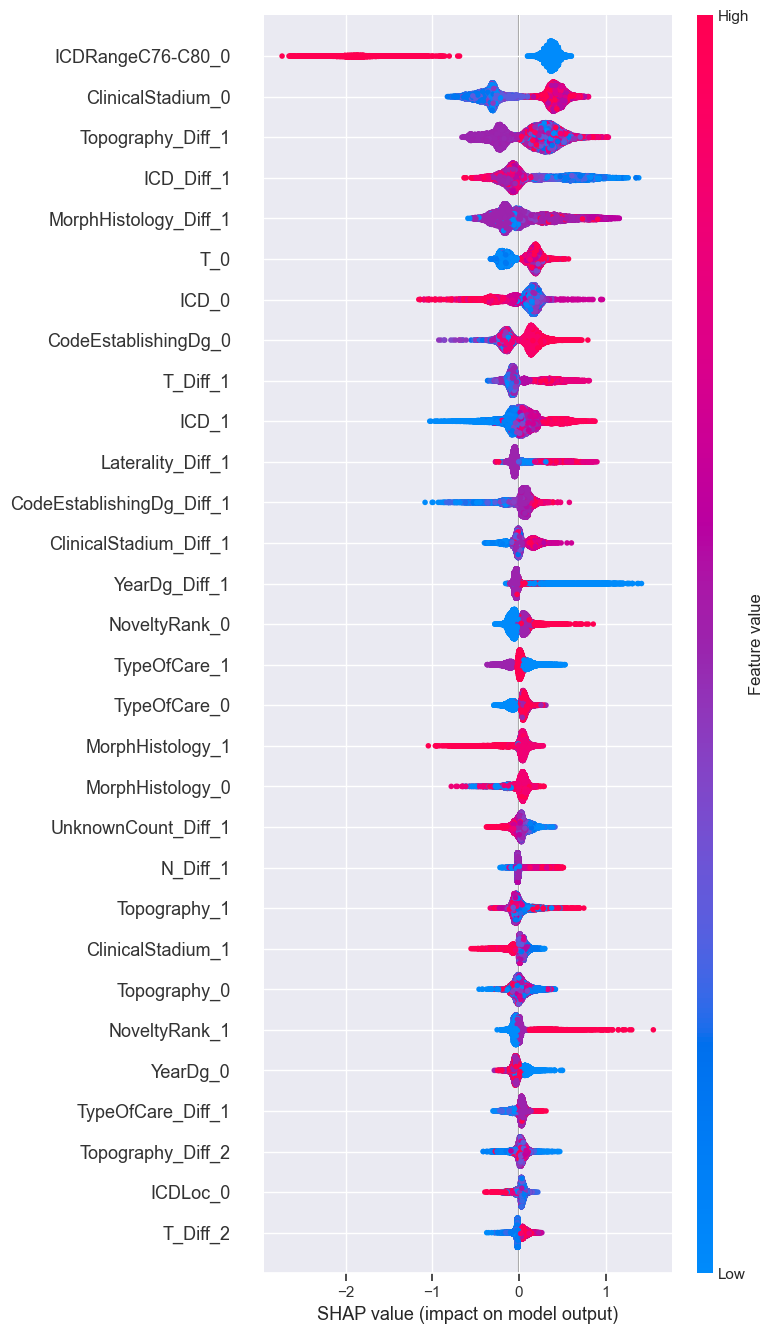

In [143]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, X_explained, max_display=30)

#### Dependence plots

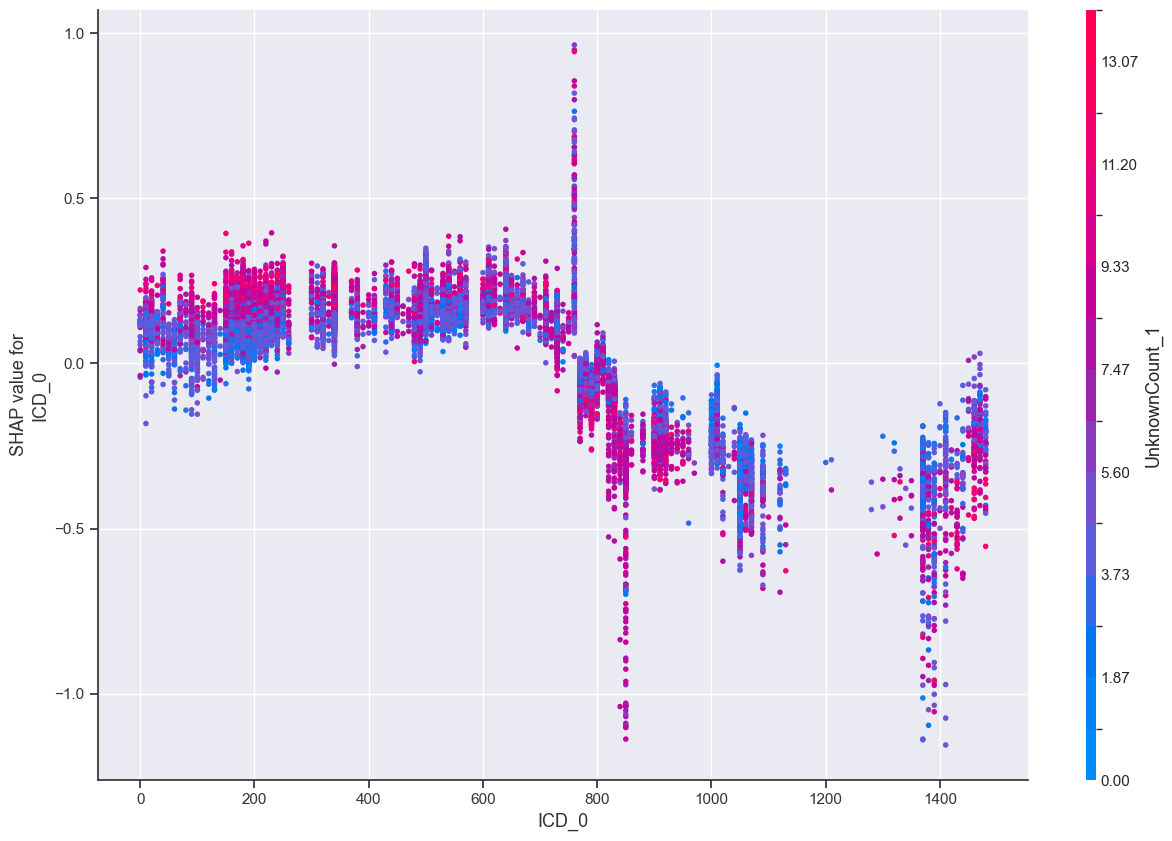

In [144]:
from matplotlib import pyplot as plt


def shap_dependence_plot(col_name: str, interaction_index: str | None = None, ax=None):
    kwargs = {
        "ax": ax,
    }

    if interaction_index is not None:
        kwargs["interaction_index"] = interaction_index

    shap.dependence_plot(
        col_name,
        shap_values.values,
        X_explained,
        **kwargs,
    )


_, ax = plt.subplots(figsize=(15, 10))
shap_dependence_plot("ICD_0", ax=ax)

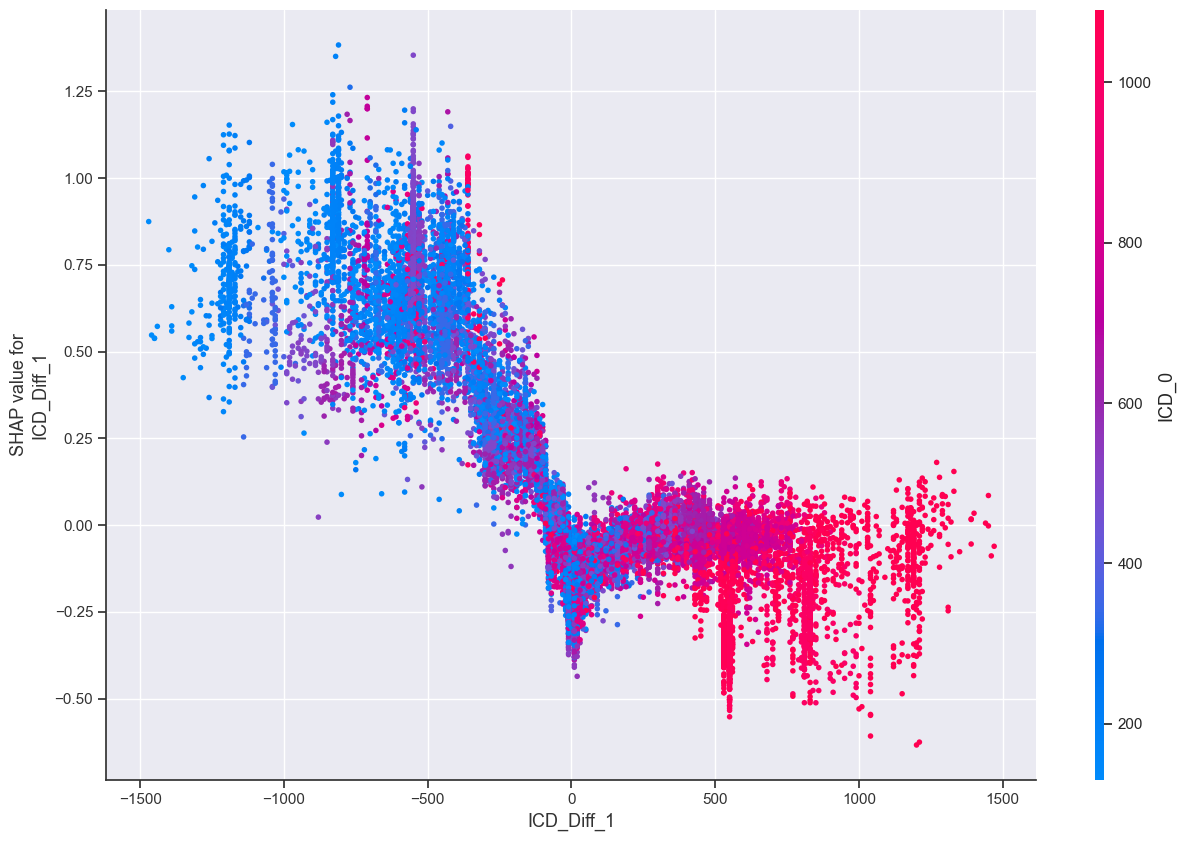

In [146]:
_, ax = plt.subplots(figsize=(15, 10))
shap_dependence_plot("ICD_Diff_1", ax=ax, interaction_index="ICD_0")

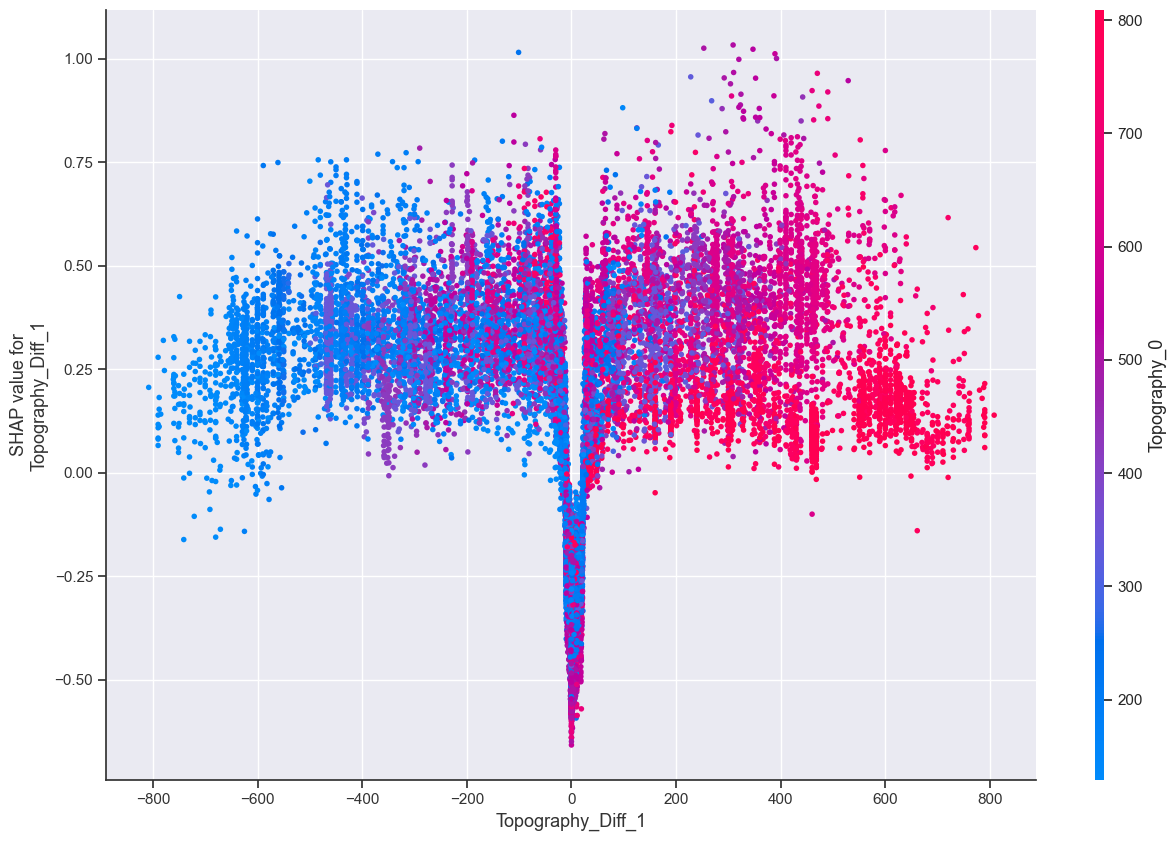

In [147]:
_, ax = plt.subplots(figsize=(15, 10))
shap_dependence_plot("Topography_Diff_1", ax=ax, interaction_index="Topography_0")

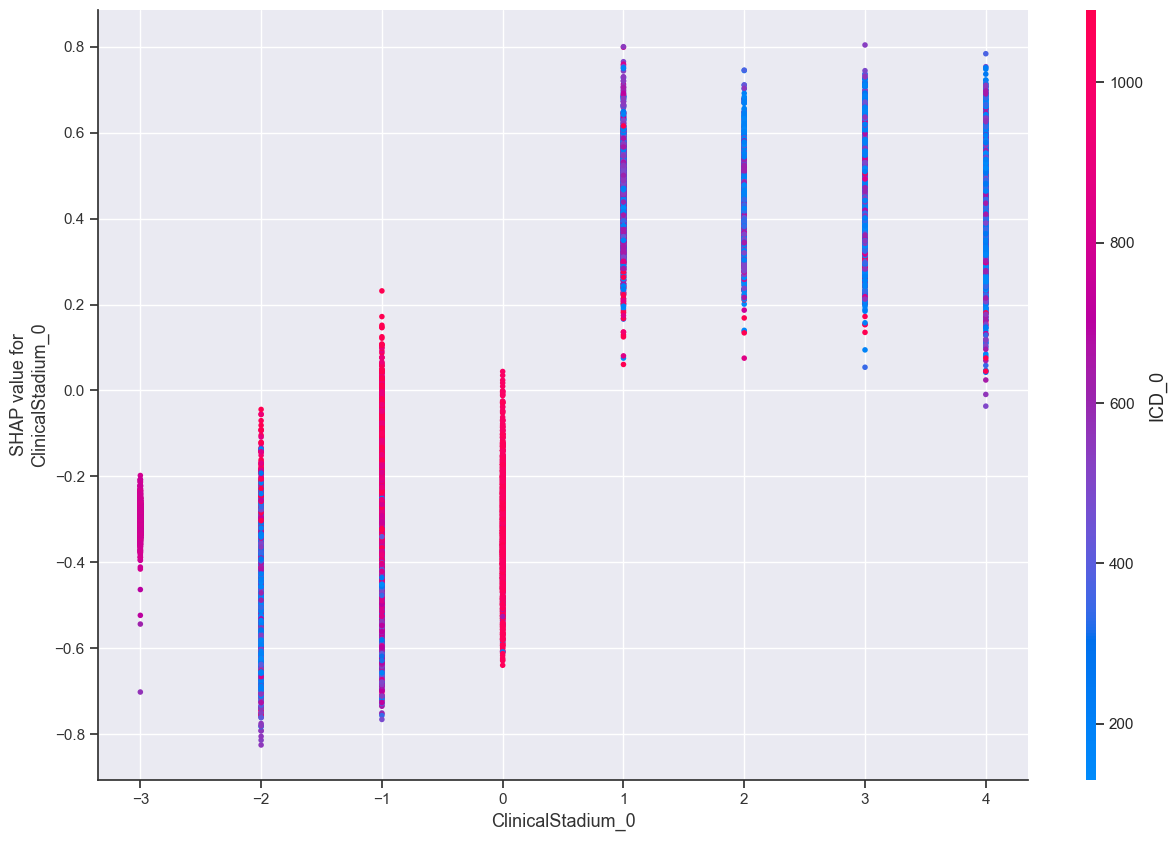

In [148]:
_, ax = plt.subplots(figsize=(15, 10))
shap_dependence_plot("ClinicalStadium_0", ax=ax)

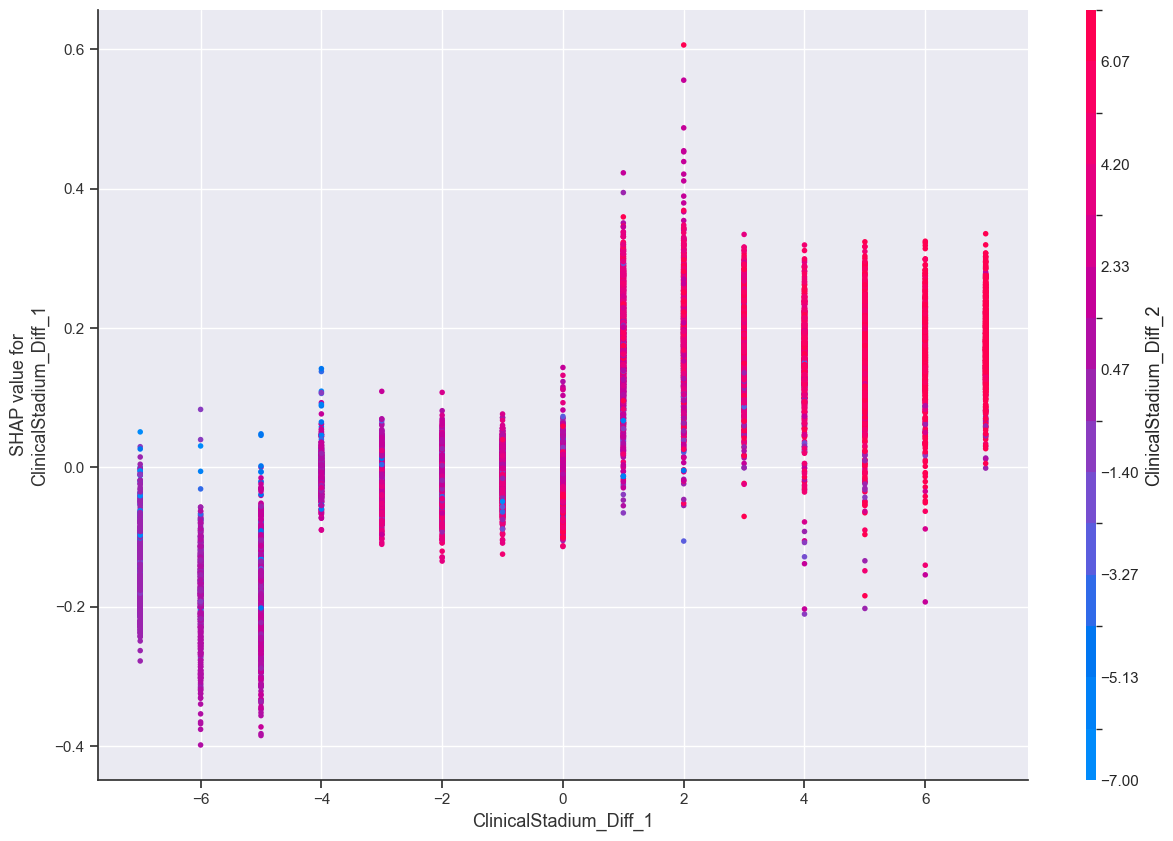

In [149]:
_, ax = plt.subplots(figsize=(15, 10))
shap_dependence_plot("ClinicalStadium_Diff_1", ax=ax)

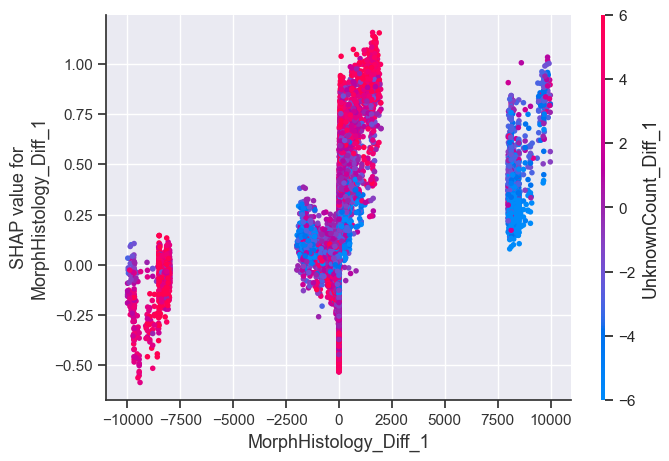

In [150]:
shap_dependence_plot("MorphHistology_Diff_1")

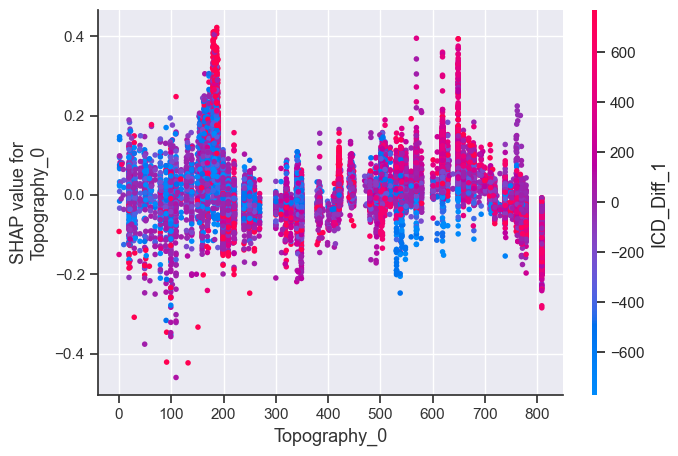

In [151]:
shap_dependence_plot("Topography_0")

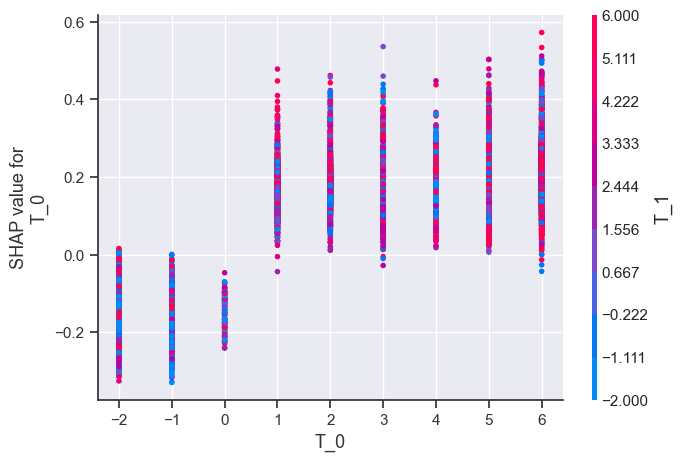

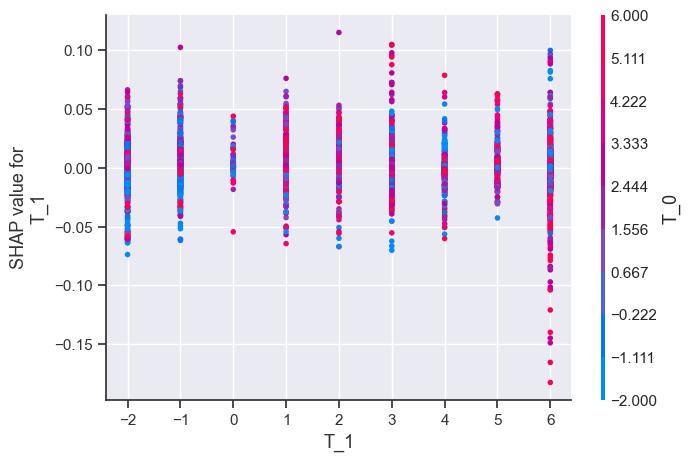

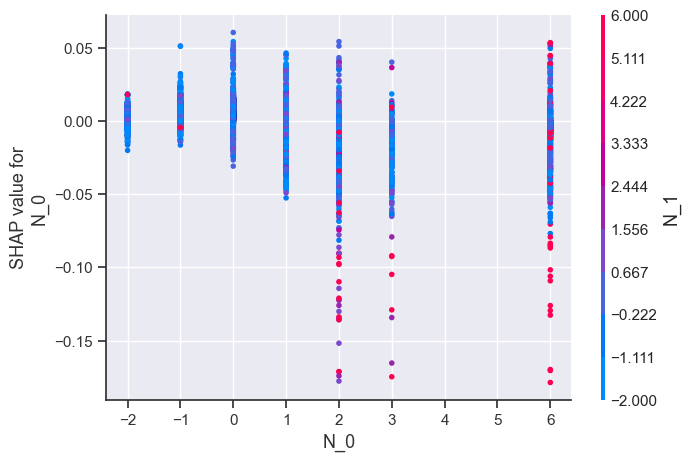

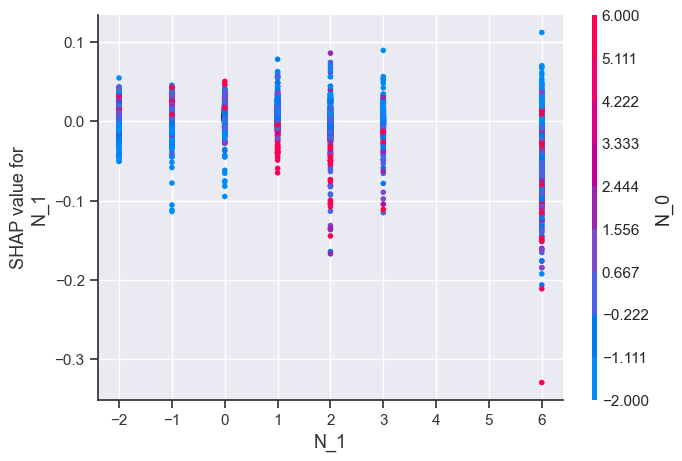

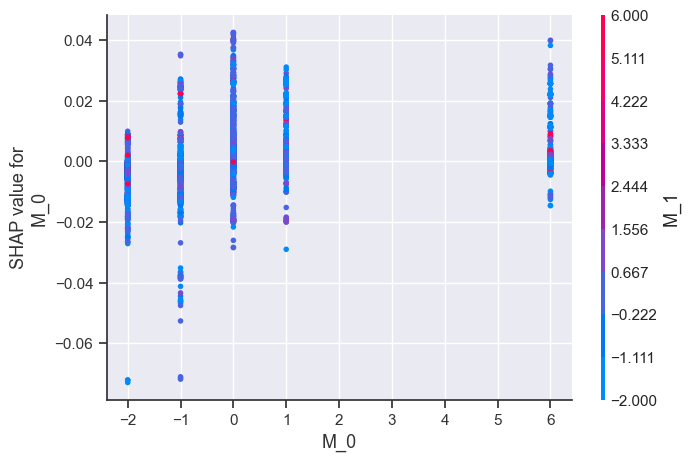

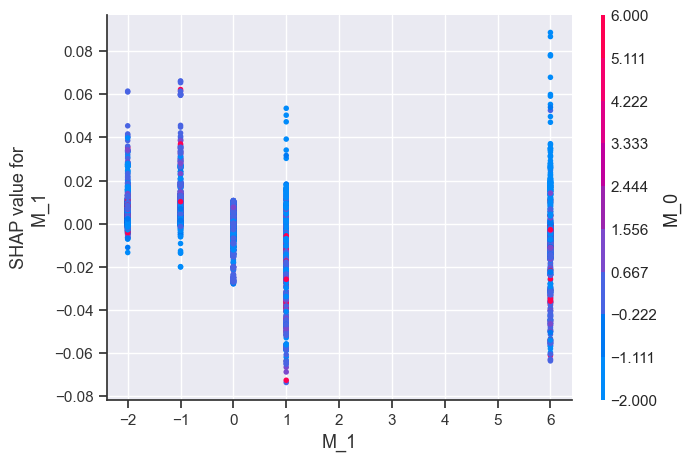

In [152]:
to_plot = [
    "T_0",
    "T_1",
    "N_0",
    "N_1",
    "M_0",
    "M_1",
]

for i, col in enumerate(to_plot):
    shap.dependence_plot(
        col,
        shap_values.values,
        X_explained,
        interaction_index=to_plot[i + 1] if i % 2 == 0 else to_plot[i - 1],
    )

#### Waterfall Plots

In [20]:
def waterfall_plot(
    X: pd.DataFrame,
    y: pd.Series,
    y_pred: pd.Series,
    shap_values: np.ndarray,
    index: int,
    by_patient_id: bool = False,
    max_display: int = 15,
    position: int = 0,
    show: bool = True,
) -> int:
    """
    Plot the waterfall plot for the given index.
    Parameters:
        X: dataframe with the data
        y: true values
        y_pred: predicted values
        shap_values: shap values
        index: index of the patient
        by_patient_id: whether to find the index by patient id
        max_display: maximum number of features to display
        position: in case of duplicate indices, take the position-th index
        show: whether to show the plot. If False, the plot is not shown, but is
        in plt.gca()
    
    Returns:
        int:
            index of the patient in the dataframe
    """
    if by_patient_id:
        index = X.index.get_loc(index)

        # If the index has multiple values, take the position-th value
        if isinstance(index, slice):
            index = index.start + position
        elif not isinstance(index, int):
            raise ValueError(f"Index is not an integer nor a slice: {index}")

    print(f"Index: {index}")

    # pacient_id = patient_ids[index]
    # print(f"PacientId: {pacient_id}")

    print(f"True value: {y.iloc[index]}")
    print(f"Predicted value: {y_pred.iloc[index]}")

    print("Number of records:", int(X.iloc[index]["RecordCount_0"]))

    shap.plots.waterfall(
        shap_values[index], max_display=max_display, show=show
    )

    return index


def get_probability(model, X: pd.DataFrame, index: int) -> float:
    """
    Get the probability of the positive class for the given index.
    """
    return model.predict_proba(X.iloc[[index]].to_numpy())[0, 1]


def print_probability(model, X: pd.DataFrame, index: int) -> None:
    """
    Print the probability of the positive class for the given index.
    """
    print(
        f"Probability of being positive: {get_probability(model, X, index): .4f}"
    )

Index: 7886
True value: 0
Predicted value: 1
Number of records: 2


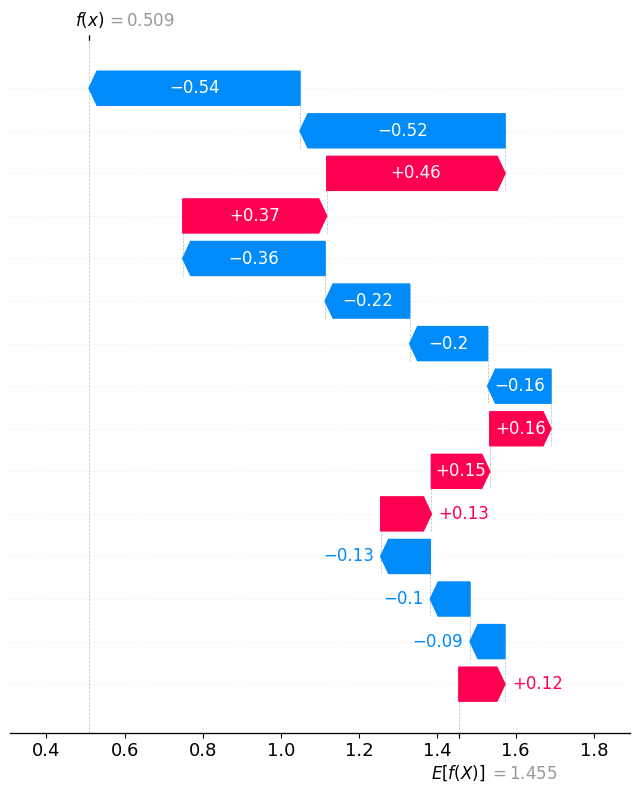

Probability of accepting the record: 0.6245785


In [22]:
import matplotlib.pyplot as plt

waterfall_plot(
    X_explained,
    y_explained,
    y_pred_explained,
    shap_values,
    7886,
    max_display=15,
    by_patient_id=False,
    show=False,
)


ax = plt.gca()
# Hide y ticks due to GDPR
ax.set_yticks([])
plt.show(
    ax.get_figure(),
)

print("Probability of accepting the record:", get_probability(xgbc_shap, X_explained, 7886))

## Export Wrong Predictions of XGB+C

In [25]:
from lib.wrong_preds_cross_val import get_wrong_preds_cross_val
from lib.load_dataset import get_original_dataset


# do_export = False
do_export = True


def export_wrong_preds() -> None:
    X_merged, y_merged, report_ids, patient_ids = load_merged_data(which="2022")

    X_merged_reset_index = X_merged.reset_index(drop=True, level=0)
    y_merged_reset_index = y_merged.reset_index(drop=True)

    wrong_preds_cross_val_df = get_wrong_preds_cross_val(
        xgb.XGBClassifier(**XGBC_HYPERPARAMS),
        X_merged_reset_index.drop(columns=["PatientId", "RecordId"]),
        y_merged_reset_index,
        groups=patient_ids,
        add_proba=True,
        verbose=True,
        augment_data=True,
        n=TAKE_RANGE[1],
    )

    # Get the true values
    trues = y_merged_reset_index.iloc[
        wrong_preds_cross_val_df["index"]
    ].reset_index(drop=True)

    wrong_preds_cross_val_df = wrong_preds_cross_val_df.assign(
        HlaseniIdDtb=report_ids.iloc[wrong_preds_cross_val_df["index"]][
            0
        ].reset_index(drop=True),
        # PacientId=patient_ids.iloc[
        #     wrong_preds_cross_val_df["index"]
        # ].reset_index(drop=True),
        true_value=trues,
        prediction=1 - trues,
    )

    X_merged_reset_index.columns = [
        f"{col_name}_{col_num}" if col_num != "" else col_name
        for col_name, col_num in X_merged_reset_index.columns
    ]

    X_merged_reset_index = pd.concat(
        [report_ids[0].reset_index(drop=True), X_merged_reset_index],
        axis=1,
    )

    # Merge with merged X
    wrong_preds_cross_val_df = wrong_preds_cross_val_df.merge(
        X_merged_reset_index,
        how="inner",
        left_on="HlaseniIdDtb",
        right_on=0,
    )

    # Drop index column
    wrong_preds_cross_val_df.drop(columns=["index", 0], inplace=True)

    wrong_preds_cross_val_df.rename(
        columns={"proba": "probability"}, inplace=True
    )

    print(
        "Total number of wrong predictions:", wrong_preds_cross_val_df.shape[0]
    )

    # Assert that the ids of reports are unique and no null values
    assert wrong_preds_cross_val_df["HlaseniIdDtb"].is_unique
    assert wrong_preds_cross_val_df["HlaseniIdDtb"].notnull().all()

    data_expert = get_original_dataset(which="2022")

    wrong_preds_cross_val_df = wrong_preds_cross_val_df.merge(
        data_expert[["HlaseniIdDtb", "vyporadani_final"]],
        on="HlaseniIdDtb",
        how="left",
    )
    assert wrong_preds_cross_val_df["vyporadani_final"].isnull().sum() == 0

    wrong_preds_cross_val_df.rename(
        {"vyporadani_final": "vyporadani_predtym"}, axis=1, inplace=True
    )

    # Export the wrong predictions
    wrong_preds_cross_val_df.to_csv(
        f"./data/wrong_preds_cross_val_2019_2022.csv", index=False
    )


if do_export:
    export_wrong_preds()

Fold: 0
Accuracy: 0.8936406995230525
Number of wrong predictions: 669
Fold: 1
Accuracy: 0.8953895071542131
Number of wrong predictions: 658
Fold: 2
Accuracy: 0.898394021307044
Number of wrong predictions: 639
Fold: 3
Accuracy: 0.8933057719828271
Number of wrong predictions: 671
Fold: 4
Accuracy: 0.8950548576880267
Number of wrong predictions: 660
Total number of wrong predictions: 3297


## Verification on New Records

In [ ]:
from lib.utils import drop_ids
from lib.load_dataset import load_merged_data

X_train_new = drop_ids(X_merged)
y_train_new = y_merged.copy()

X_new, y_new, _, _ = load_merged_data(which="verify_dataset")
X_new = drop_ids(X_new)

# Train the model 
xgb_c_test = xgb.XGBClassifier(**XGBC_HYPERPARAMS)
xgb_c_test.fit(X_train_new, y_train_new)
None

In [ ]:
print(X_train_new.shape)
print(X_new.shape)

(21297, 116)
(9765, 116)


### XGB+C

22/05/2024 19:19:20
Evaluations

Accuracy:
Train: 94.1072 %
Test: 89.5545 %

F1 Score:
Train: 0.849
Test: 0.676

Precision:
Train: 0.888
Test: 0.746

Recall:
Train: 0.814
Test: 0.618

AUC:
Train: 0.982
Test: 0.923

Validation dataset confusion matrix:
Validation dataset not found

Confusion matrices (plots):


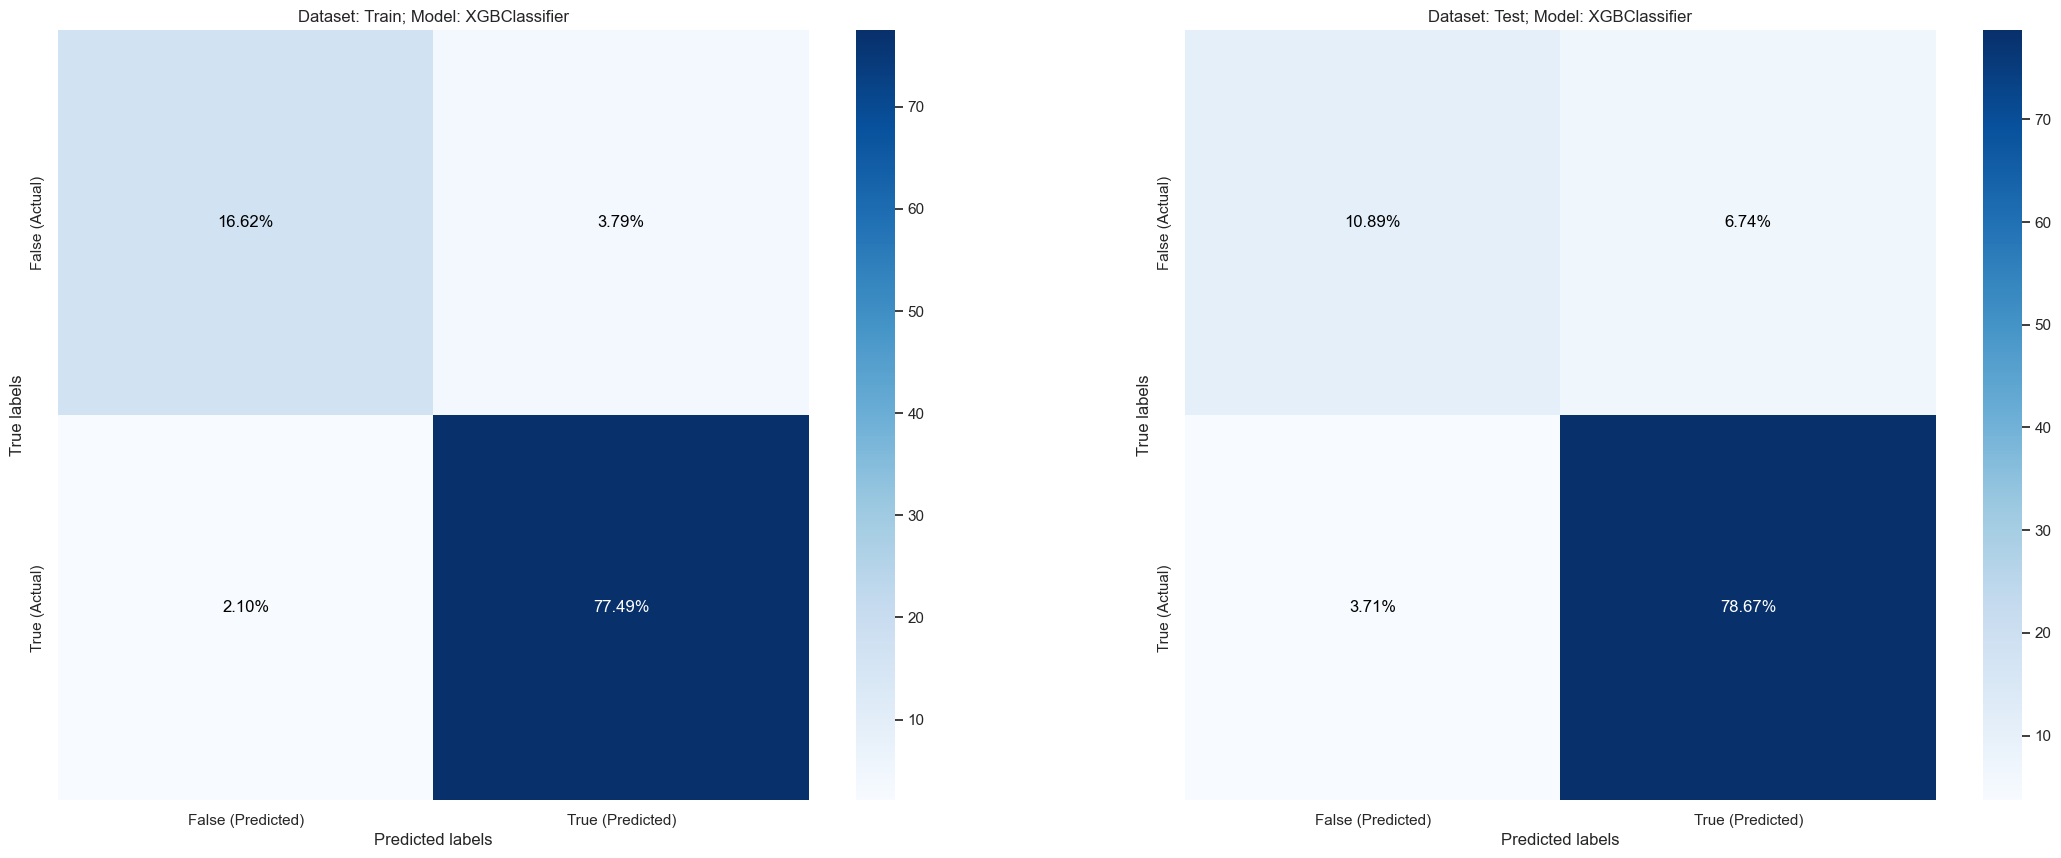

In [ ]:
# Evaluate the model
evaluate_model(
    xgb_c_test,
    [
        ("Train", X_train_new, y_train_new),
        ("Test", X_new, y_new),
    ],
)

In [ ]:
from lib.eval import evaluate_by_report_count

y_pred = pd.Series(xgb_c_test.predict(X_new))
y_score = pd.Series(xgb_c_test.predict_proba(X_new)[:, 1])

scores = evaluate_by_report_count(
    X_new,
    y_new,
    y_pred,
    TAKE_RANGE,
    record_count_getter=lambda df: df["RecordCount"][0],
    y_score=y_score,
)

for i in scores.keys():
    print("Group", i)
    for k, v in scores[i].items():
        print(f"{k}: {round(v, 3)}")

Group 2
test_accuracy: 0.9
test_f1: 0.681
test_precision: 0.744
test_recall: 0.628
test_roc_auc: 0.925
Group 3
test_accuracy: 0.865
test_f1: 0.643
test_precision: 0.758
test_recall: 0.559
test_roc_auc: 0.914


### XGB+CD

In [ ]:
from lib.merge_records import augment_merged_x_y_df

X_train_new_augmented, y_train_new_augmented = augment_merged_x_y_df(
    X_train_new, y_train_new, TAKE_RANGE[1]
)

print(X_train_new_augmented.shape)

(42594, 116)


22/05/2024 19:20:06
Evaluations

Accuracy:
Train: 94.5955 %
Test: 89.6569 %

F1 Score:
Train: 0.863
Test: 0.679

Precision:
Train: 0.896
Test: 0.749

Recall:
Train: 0.831
Test: 0.621

AUC:
Train: 0.984
Test: 0.922

Validation dataset confusion matrix:
Validation dataset not found

Confusion matrices (plots):


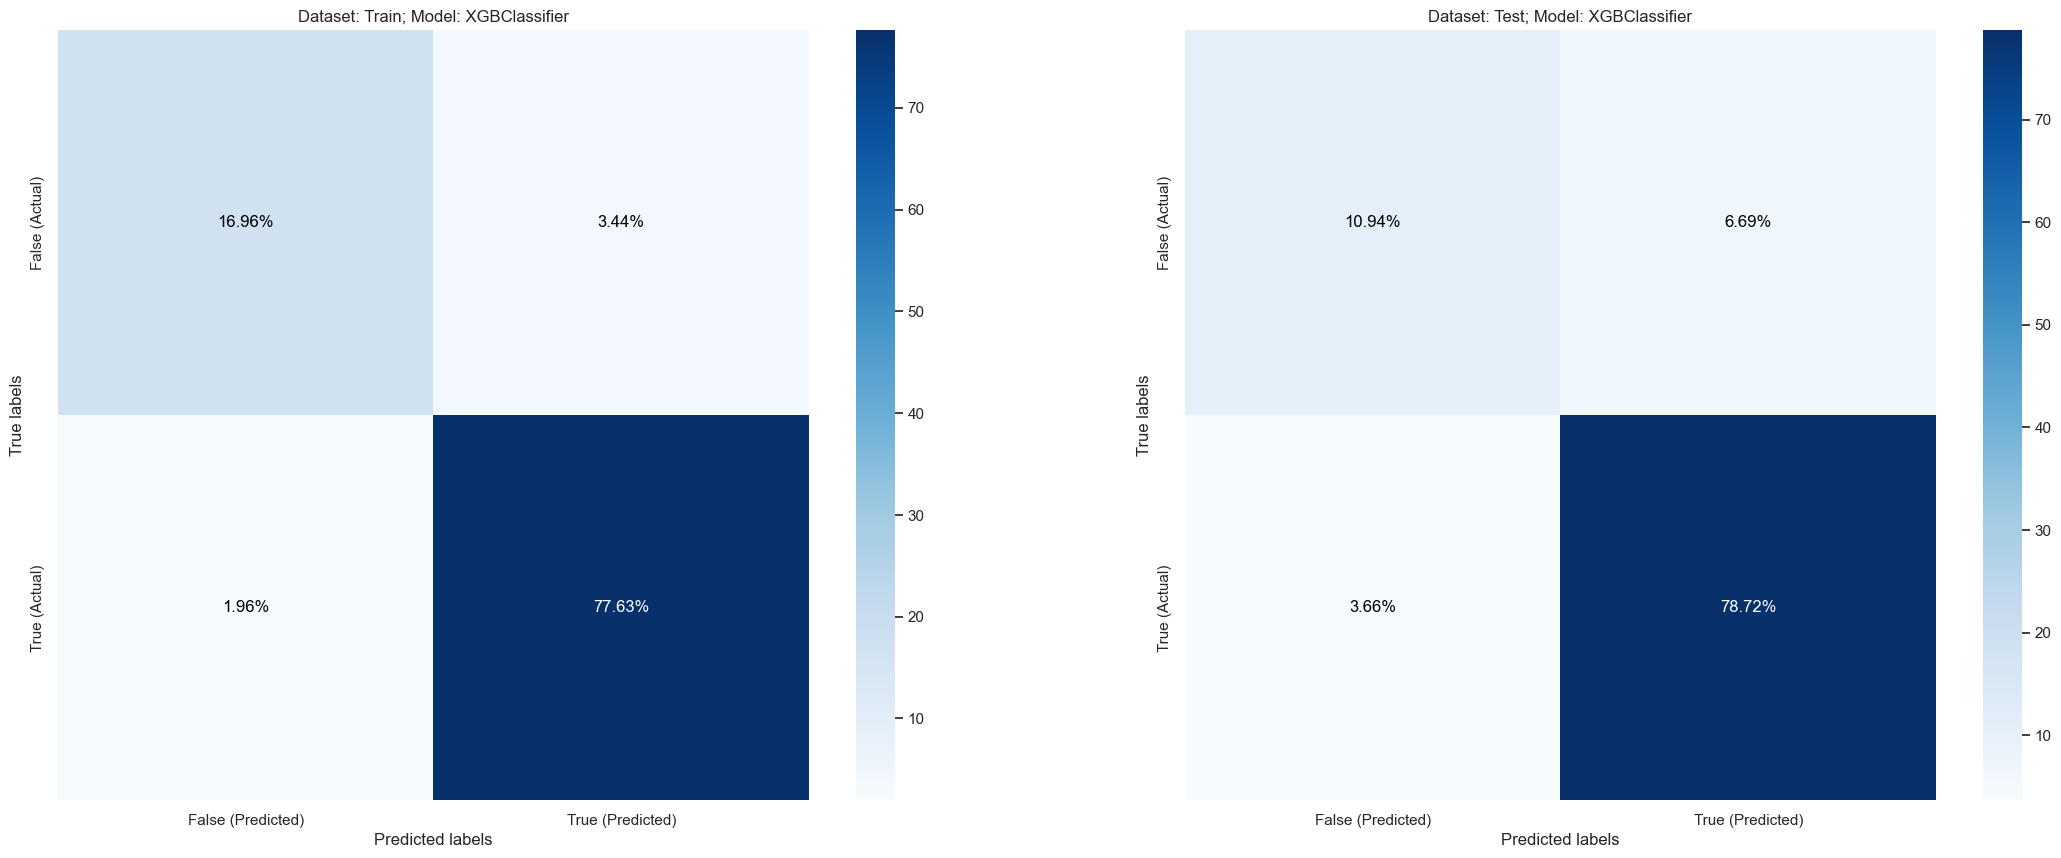

In [ ]:
xgb_cd_test = xgb.XGBClassifier(**XGBC_HYPERPARAMS)
xgb_cd_test.fit(X_train_new_augmented, y_train_new_augmented)

evaluate_model(
    xgb_cd_test,
    [
        ("Train", X_train_new_augmented, y_train_new_augmented),
        ("Test", X_new, y_new),
    ],
)

In [ ]:
from lib.eval import evaluate_by_report_count

y_pred = pd.Series(xgb_cd_test.predict(X_new))
y_score = pd.Series(xgb_cd_test.predict_proba(X_new)[:, 1])

scores = evaluate_by_report_count(
    X_new,
    y_new,
    y_pred,
    TAKE_RANGE,
    record_count_getter=lambda df: df["RecordCount"][0],
    y_score=y_score,
)

for i in scores.keys():
    print("Group", i)
    for k, v in scores[i].items():
        print(f"{k}: {round(v, 3)}")

Group 2
test_accuracy: 0.901
test_f1: 0.684
test_precision: 0.75
test_recall: 0.628
test_roc_auc: 0.924
Group 3
test_accuracy: 0.865
test_f1: 0.651
test_precision: 0.745
test_recall: 0.578
test_roc_auc: 0.908


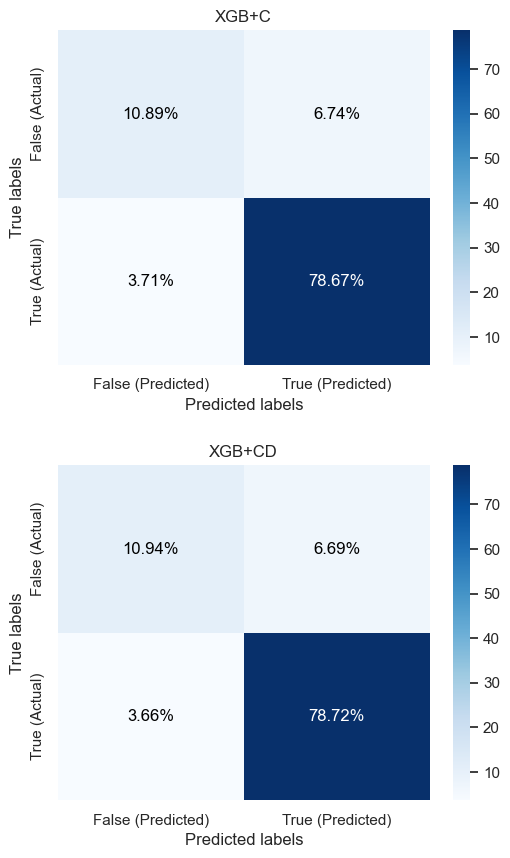

In [ ]:
from lib.eval import plot_confussion_matrix
import matplotlib.pyplot as plt


_, axes = plt.subplots(ncols=1, nrows=2, figsize=(6, 10))

plot_confussion_matrix(y_new, xgb_c_test.predict(X_new), ax=axes[0])
plot_confussion_matrix(y_new, xgb_cd_test.predict(X_new), ax=axes[1])

axes[0].set_title("XGB+C")
axes[1].set_title("XGB+CD")

plt.subplots_adjust(hspace=0.3)